In [2]:
from matplotlib import pyplot as plt
from PIL import Image
from keras.datasets import cifar10
import random
import numpy as np
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
num_classes = 10
epochs = 100
batch_num = 32
batch_num_validate = 8
steps_per_epoch = len(x_train) // batch_num
y_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [5]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

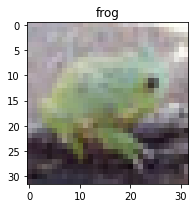

In [6]:
fig = plt.figure(tight_layout='auto', figsize=(3, 3))
ran = random.randint(3, 50000)
plt.title(y_labels[np.argmax(y_train[ran])])
plt.imshow(x_train[ran])
plt.show()

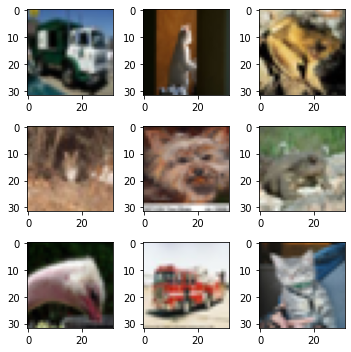

In [7]:
fig = plt.figure(tight_layout='auto', figsize=(5, 5))
for i in range(9):
	fig.add_subplot(330 + 1 + i)
	plt.imshow(x_train[random.randint(3, 50000)])
plt.show()

In [8]:
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, 
                         fill_mode="nearest", rescale=1./255)
it = datagen.flow(x_train, y_train, batch_size=32)

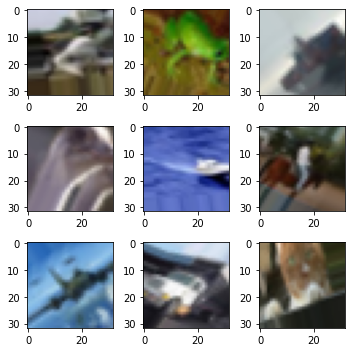

In [9]:
fig = plt.figure(tight_layout='auto', figsize=(5, 5))
for i in range(1):
	batch = it.next()
	for j in range(9):
		fig.add_subplot(330 + 1 + j)
		image = (batch[0][j]*255).astype('uint8')
		plt.imshow(image)
plt.show()

In [10]:
def build_unet(shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(48, 3, activation='relu', padding='same', input_shape=shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(48, 3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(48, 5, activation='relu', padding='same', strides=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, 5, activation='relu', padding='same', strides=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, 5, activation='relu', padding='same', strides=2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(256, 4, activation='relu', padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [11]:
model = build_unet((32, 32, 3), 10)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 48)        1344      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 48)       192       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 48)        20784     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 48)       192       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 48)        57648     
                                                                 
 batch_normalization_2 (Batc  (None, 16, 16, 48)       1

In [12]:
model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

In [13]:
callbacks = [
        ModelCheckpoint("augment.h5", verbose=1, save_best_model=True),
        ReduceLROnPlateau(monitor="categorical_accuracy", patience=3,
                          factor=0.1, verbose=1, min_lr=1e-6),
        CSVLogger("augment.csv"),
        EarlyStopping(monitor="categorical_accuracy", patience=5, verbose=1)
    ]

In [14]:
model.fit(datagen.flow(x_train, y_train, batch_size=32),
         steps_per_epoch=len(x_train) / 32, epochs=epochs, validation_data=(x_test,y_test))

1562/1562 [==============================] - 37s 19ms/step - loss: 1.9575 - acc: 0.2808 - val_loss: 71.5777 - val_acc: 0.1307
